### 0. Import Dependencies

In [8]:
import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

### 1.a. Data processing (FER 2013 Dataset)

Firstly, we create a function that will return the images and the labels, given a dataset:

In [29]:
# class names
classes_map = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}

def load_dataset(dataset_path):
    images, labels = [], []
    for folder in os.listdir(dataset_path):
        label = str(folder)
        print(label)
        for label in os.listdir(dataset_path + folder):
            for file in os.listdir(dataset_path + folder + '/' + label):
                image = cv2.imread(dataset_path + folder + '/' + label + '/' + file)
                image = cv2.resize(image, (224, 224))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.transpose(image, (2, 0, 1))
                image = torch.tensor(image, dtype=torch.float32)
                image = image.unsqueeze(0)
                yield image, classes_map[label]

print(load_dataset('/data/affectnet/images/'))

<generator object load_dataset at 0x7751b1feec70>


The dataset was taken from this source: https://www.kaggle.com/code/ayushsaini04/face-expression-recognition-with-deep-learning

All images have a resolution 48x48. The images appearing in the plot are random images of the train dataset.

In [21]:
# input path for the images FER 2013
base_path = "data/fer2013/images/"

Let's count the number of images for each facial expression in the FER 2013 dataset:

In [13]:
import os
print("No. of images in the training split: (FER dataset) ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: (FER dataset)")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: (FER dataset) 
3205 surprise images
436 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: (FER dataset)
797 surprise images
111 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


The "disgust" images appear to be much lesser than the other categories. This significant imbalance could potentially cause problems to the model.

A good solution to this issue is to augment the images of the "disgust" dataset, so that we create more samples of this class and thus improve the model's accuracy.

Original: 


/tmp/ipykernel_212543/618094824.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))


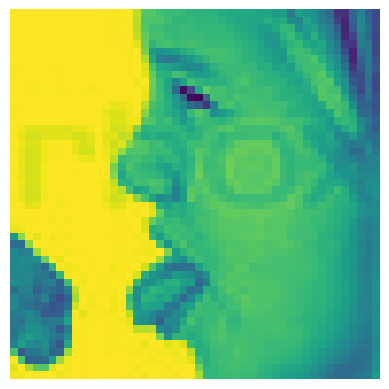

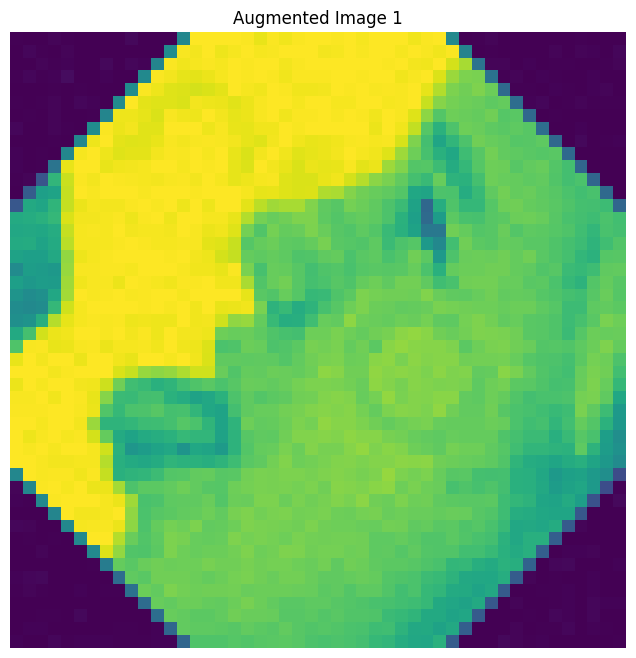

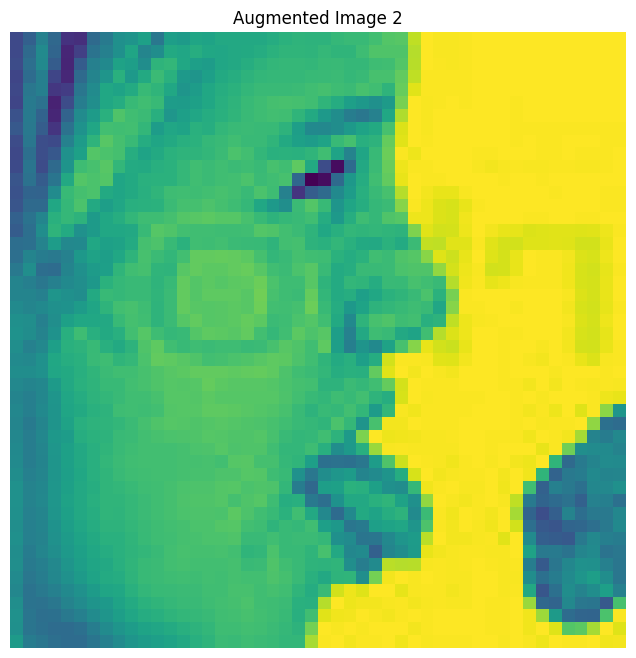

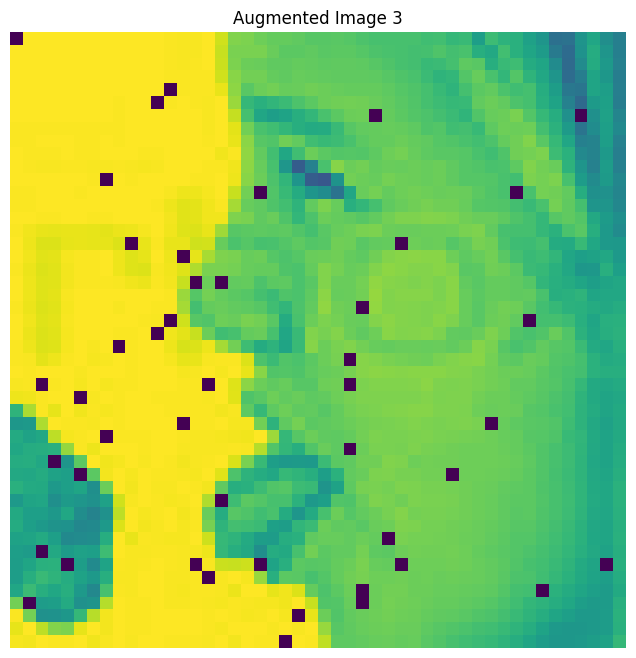

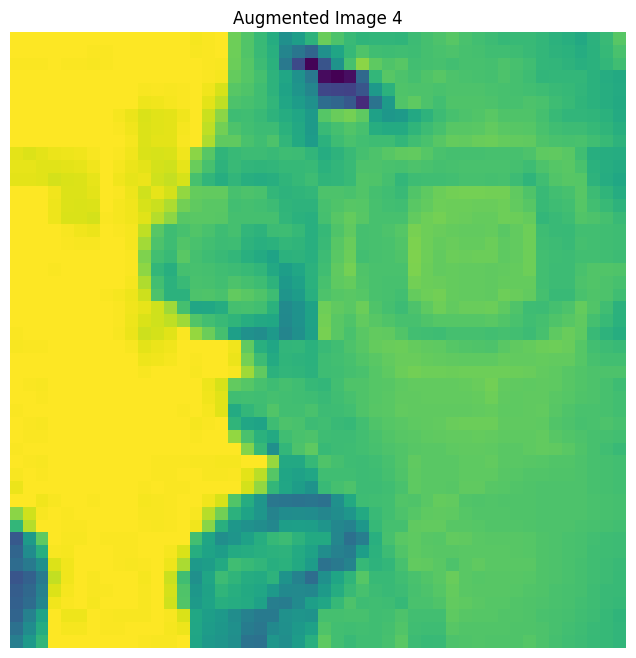

In [15]:
# Load a random image and display it

import imageio
import imgaug as ia
import matplotlib.pyplot as plt
import random

%matplotlib inline

disgust_path = base_path + "/train/disgust/"
disgust_path_val = base_path + "/validation/disgust/"
image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))

print("Original: ")
plt.imshow(image)
plt.axis('off')
plt.show()

# Augment the Image

from imgaug import augmenters as iaa
ia.seed(4)

# Define different sequential augmenters
seq1 = iaa.Sequential([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.01*255)
])

seq2 = iaa.Sequential([
    iaa.Fliplr(1)  # Horizontal flip
])

seq3 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.01, 0.05)),
    iaa.Dropout(p=(0.01, 0.05)),
])

seq4 = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)),  # random crops
    iaa.Sharpen(alpha=(0.01, 0.05))  # sharpen the image
])

# List of all sequentials
sequentials = [seq1, seq2, seq3, seq4]


for i, seq in enumerate(sequentials, start=1):
    # Apply augmentation
    image_aug = seq(image=image)
    
    # Display the augmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_aug)
    plt.axis('off')
    plt.title(f'Augmented Image {i}')
    plt.show()

We are going to do the same thing as in the above cell but for all the images in the "disgust" folder, in order to increase the number of samples we are going to use for our training.

(In case we want to delete some of the images we just created, we can run this script) :

In [ ]:
import os

disgust_path = "data/archive/images/train/disgust/" # add the path here
disgust_path_val = "data/archive/images/validation/disgust/"
# List all files in the directory
files_in_directory = os.listdir(disgust_path) 
files_in_directory_val = os.listdir(disgust_path_val)
files_to_delete = []

# Filter for files that end with '_aug.jpg'
for file in files_in_directory:    
    for i in range(0, 5):
        if file.endswith(f'_aug{i}.jpg'):
            files_to_delete.append(file)

# Delete the files
for file in files_to_delete:
    os.remove(os.path.join(disgust_path, file))
    print(f"Deleted {file}")

files_to_delete = []

for file in files_in_directory_val:
    for i in range(0, 5):
        if file.endswith(f'_aug{i}.jpg'):
            files_to_delete.append(file)

for file in files_to_delete:
    os.remove(os.path.join(disgust_path_val, file))
    print(f"Deleted {file}")


In [18]:
run_once=False

Now we create the new augmented pictures:

In [19]:
if run_once == False:
    for pic in os.listdir(disgust_path):
        image = imageio.imread(disgust_path + pic)
        for i, seq in enumerate(sequentials, start=1):
            image_aug = seq(image=image)
            imageio.imwrite(os.path.join(disgust_path, pic[:-4] + f"_aug{i}.jpg"), image_aug)
    
    for pic in os.listdir(disgust_path_val):
        image = imageio.imread(disgust_path_val + pic)
        for i, seq in enumerate(sequentials, start=1):
            image_aug = seq(image=image)
            imageio.imwrite(os.path.join(disgust_path_val, pic[:-4] + f"_aug{i}.jpg"), image_aug)
if run_once == True:
    print("Augmentation already done")
run_once = True

/tmp/ipykernel_212543/3999746029.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + pic)
/tmp/ipykernel_212543/3999746029.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path_val + pic)


In [20]:
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
2180 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
555 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


Now we see that our dataset is more balanced.

### 1.b. Data processing (Affectnet)

In [27]:
print("Printing number of samples in AffectNet dataset")

for expression in os.listdir("data/affectnet/images/"):
    print(str(len(os.listdir("data/affectnet/images/" + expression))) + " " + expression + " images")

Printing number of samples in AffectNet dataset
4039 surprise images
2477 disgust images
5044 happy images
3218 anger images
3091 sad images
3176 fear images
5126 neutral images


Split into train and validation set for AffectNet:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_affectnet_data(dataset_path):
    image_paths = []
    labels = []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path): 
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(image_path)
                    labels.append(label)

    return image_paths, labels

dataset_path = 'data/affectnet/images/'
affectnet_images, affectnet_labels = load_affectnet_data(dataset_path)

# Split the data into training and validation sets

label_encoder = LabelEncoder()
encoded_affectnet_labels = label_encoder.fit_transform(affectnet_labels)

affectnet_train_images, affectnet_val_images, affectnet_train_labels, affectnet_val_labels = train_test_split(affectnet_images, encoded_affectnet_labels, test_size=0.2, random_state=42, stratify=encoded_affectnet_labels)

### 2. Training

In [ ]:
import torch

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
print(f'Using device: {device}')


Firstly, we load the dataset with Data Loaders:

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torchvision import transforms, datasets, utils
from PIL import Image
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the pixel values
])

# input path for the images
base_path = "data/archive/images/"

# defining train dataset
train_dataset = datasets.ImageFolder(root=os.path.join(base_path, "train"), transform=transform)
# defining validation dataset
val_dataset = datasets.ImageFolder(root=os.path.join(base_path, "validation"), transform=transform)

# creating a DataLoader for the train dataset
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# function to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of images from train dataset
train_dataiter = iter(train_dataloader)
images, labels = next(train_dataiter)

# show images
imshow(utils.make_grid(images))


Then, we import our model:

In [ ]:
from src.emotion_cnn import Deep_Emotion

For training, we define an optimizer and a loss function, and then we ensure each batch of input data and labels are sent to GPU during our training loop:

In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score

model = EmotionCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification problems
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
best_accuracy = 0.0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device) # transfer image data and labels to GPU
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}')
    scheduler.step()
    
    # Set predictions and labels lists
    all_preds = [] 
    all_labels = []

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device) # tranfer image data and labels to GPU

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for F1 calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = 100 * correct / total
    print(f'Accuracy on the validation set: {accuracy}%')

    f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' accounts for label imbalance
    print(f'F1 Score on the validation set: {f1}')

    # Save the model if it has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")

### 3. Real-Time Webcam Feed Tests

In [ ]:
model_path = 'best_model.pth'
torch.cuda.empty_cache()

_model = EmotionCNN().to(device)
_model.load_state_dict(torch.load(model_path, map_location=device))
_model.eval() # set the model to evaluation mode

In [ ]:
# emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Start the webcam
cap2 = cv2.VideoCapture(0) # the 0 is the camera index, might need change depending on the setup

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the pixel values
])

while True:
    ret, frame = cap2.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #print("Device Name:", torch.cuda.get_device_name(0))
    if torch.cuda.is_available():
        frame_processed = transform(frame_rgb)
        frame_processed = frame_processed.unsqueeze(0).to(device) # send preprocessed frame to GPU

    # Make predictions
    with torch.no_grad():
        outputs = _model(frame_processed)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]  # Apply softmax to convert to probabilities
        probabilities = probabilities.cpu().numpy()  # Convert to numpy array

    # Get the label of the highest probability
    predicted_emotion = emotion_labels[probabilities.argmax()]

    for i, (emotion, score) in enumerate(zip(emotion_labels, probabilities)):
        label = "{}: {:.2f}%".format(emotion, score * 100)
        cv2.putText(frame, label, (10, 20 + i * 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 255, 100), 1)

    cv2.imshow('Emotion Detection', frame_rgb)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap2.release()
cv2.destroyAllWindows()